In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange

from dots.training import *
from dots.models import MLP
from dots.dots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def linspace(start, end, num):
    return rearrange(t.linspace(start, end, num), "x -> x 1")

# Learning $\sin$

In [10]:
model = MLP(1, 1, hidden = 4, hidden_size = 12)

N = 256
N_test = 64
x = linspace(0, 8, N)
y = t.sin(x)

t.manual_seed(42)
dataset = tdata.TensorDataset(x, y)
train_dataset, test_dataset = tdata.random_split(dataset, lengths = [N - N_test, N_test])
train_dataloader = tdata.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = tdata.DataLoader(test_dataset, batch_size=16, shuffle=True)

n_eps = 5

trainstate = TrainState(
    model=model,
    optimiser=t.optim.Adam(model.parameters(), lr=1e-4),
    loss_fn=t.nn.MSELoss(),
    dataloader=train_dataloader,
    test_loader=test_dataloader,
    hooks=[
        jacobian_rank_hook(linspace(0, 8, 10), epochs=n_eps),
        jacobian_rank_hook(linspace(0, 8, 100), epochs=n_eps),
        jacobian_rank_hook(linspace(0, 8, 1000), epochs=n_eps),
        sv_rank_hook(linspace(0, 8, 100), epochs=n_eps),
        sv_rank_hook(linspace(0, 8, 1000), epochs=n_eps),
        sv_rank_hook(linspace(0, 8, 10), epochs=n_eps)
    ]
)

In [13]:
trainstate.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

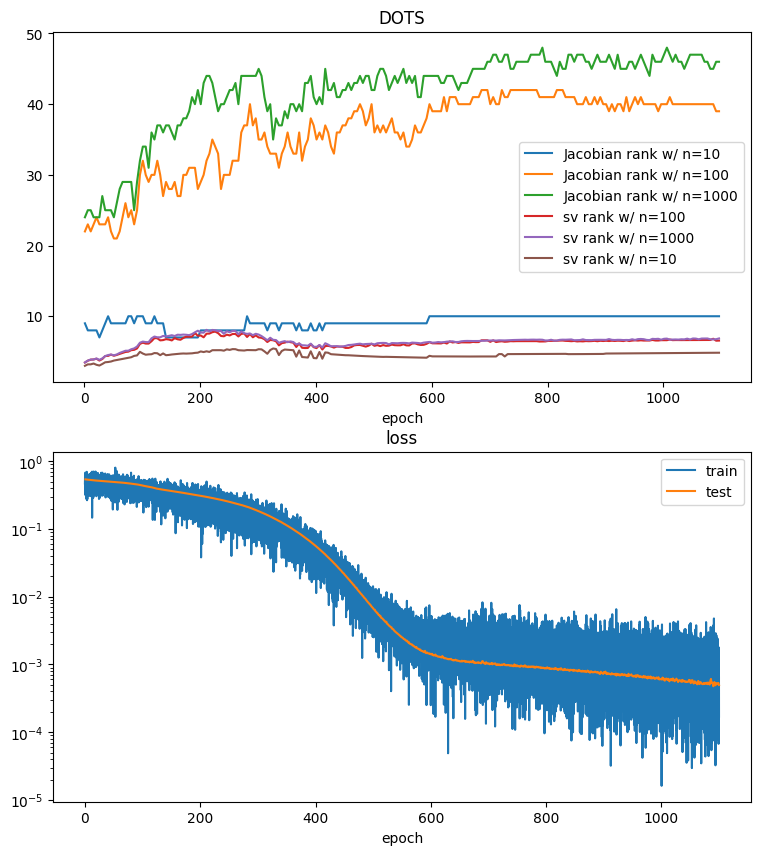

In [14]:
trainstate.plot()

In [15]:
model.count_params()

505

In [18]:
model.jacobian_matrix_rank(linspace(0, 8, 15))

tensor(14)

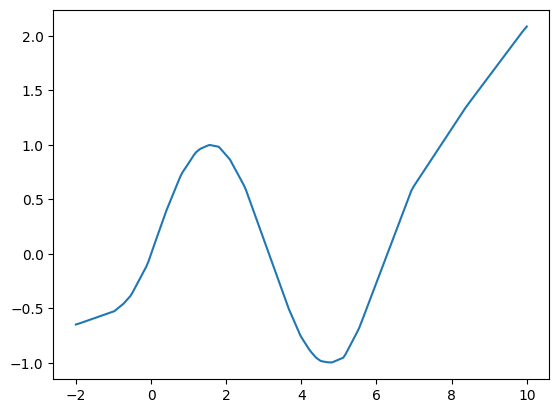

In [28]:
x_ = linspace(-2,10,200).detach()
plt.plot(x_, model(x_).detach())

# Learning $\Sigma$

In [63]:
model_s = MLP(4, 1, hidden = 4, hidden_size = 12)

t.manual_seed(42)
N = 1024 + 64
N_test = 64
x = t.rand((N, 4))
x10 = t.rand((10, 4))
x100 = t.rand((100, 4))
x1000 = t.rand((1000, 4))
y = t.sum(x, dim=1, keepdim=True)

dataset = tdata.TensorDataset(x, y)
train_dataset, test_dataset = tdata.random_split(dataset, lengths = [N - N_test, N_test])
train_dataloader = tdata.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = tdata.DataLoader(test_dataset, batch_size=16, shuffle=True)

n_eps = 20

trainstate_s = TrainState(
    model=model_s,
    optimiser=t.optim.Adam(model_s.parameters(), lr=4e-4),
    loss_fn=t.nn.MSELoss(),
    dataloader=train_dataloader,
    test_loader=test_dataloader,
    hooks=[
        jacobian_rank_hook(x10, epochs=n_eps),
        jacobian_rank_hook(x100, epochs=n_eps),
        jacobian_rank_hook(x1000, epochs=n_eps),
        sv_rank_hook(x10, epochs=n_eps),
        sv_rank_hook(x100, epochs=n_eps),
        sv_rank_hook(x1000, epochs=n_eps)
    ]
)

In [64]:
trainstate_s.train(200)

  0%|          | 0/200 [00:00<?, ?it/s]

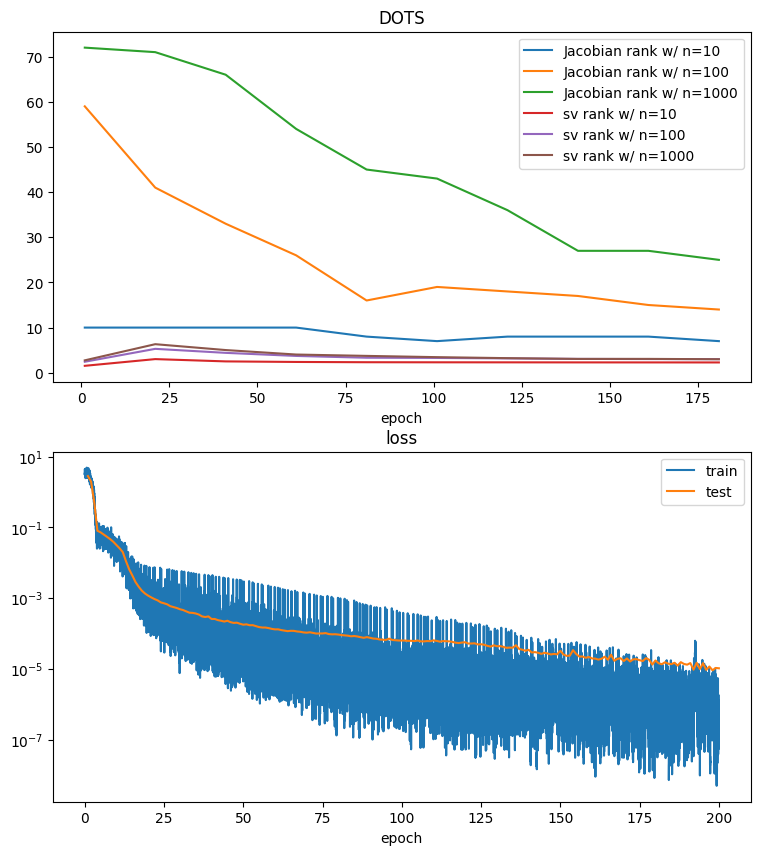

In [65]:
trainstate_s.plot()

In [66]:
model_s(t.tensor([
    [0.1, 0.1, 0.1, 0.1],
    [0.1, 0.0, 0.1, 0.2],
    [0.2, 0.0, 0.1, 0.1]
]))

tensor([[0.3919],
        [0.4148],
        [0.4087]], grad_fn=<AddmmBackward0>)